In [58]:
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

(500, 14)
Index(['timestamp', 'AccX', 'AccY', 'AccZ', 'AngX', 'AngY', 'AngZ', 'AsX',
       'AsY', 'AsZ', 'Q0', 'Q1', 'Q2', 'Q3'],
      dtype='object')


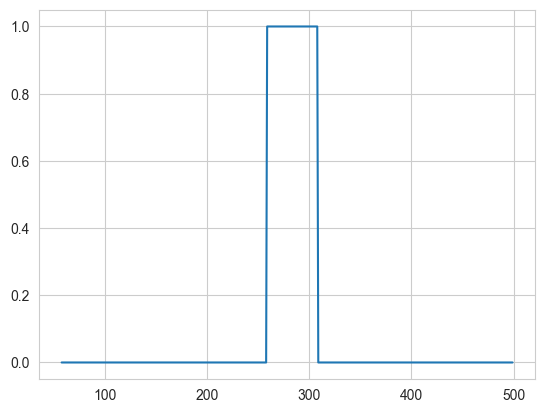

In [85]:
filename = r'imu_logs\20250428_094428.csv'
data = pd.read_csv(filename)
#data.reset_index(inplace=True,drop=True)
#data.index = data.index*10/1000  #10
timestep = 1/100
print(data.shape)
print(data.columns)
data['total_acc_change']= (data[['AccX', 'AccY', 'AccZ']].diff().rolling(10).mean().sum(axis=1).abs())
data['active_period'] = (data['total_acc_change']>0.5).astype(int).rolling(10).min().rolling(50).max()#.shift(-20)
data['active_period'].plot()
#data = data[data['active_period']==1]
df = data

<Axes: >

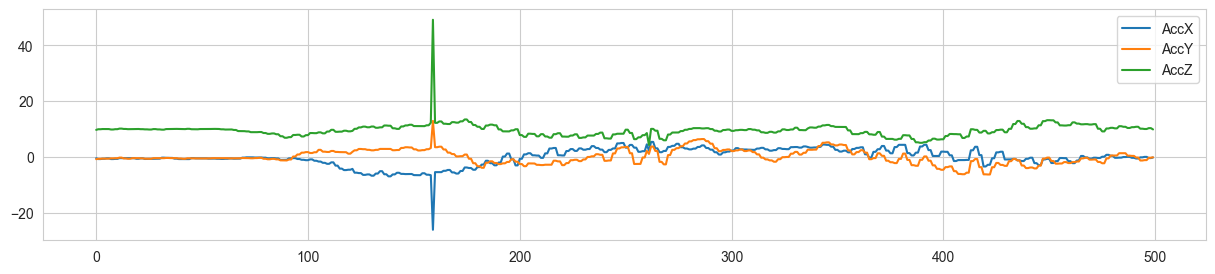

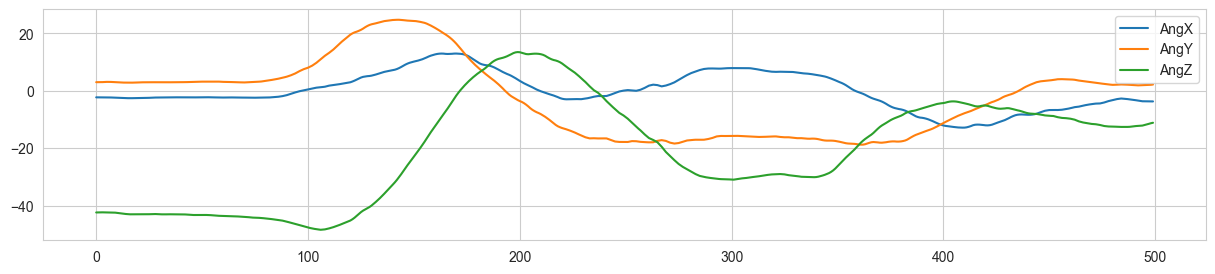

In [86]:
data[['AccX', 'AccY', 'AccZ']].plot(figsize=(15,3))
data[['AngX', 'AngY', 'AngZ']].plot(figsize=(15,3))
#data[['Q0','Q1','Q2','Q3']].plot(figsize=(15,3))


In [80]:
# --------------------------------------------------------------------
#   IMU 3-D TRAJECTORY  —  High-rate Yaw from Gyro, Up-vector Cal
# --------------------------------------------------------------------
#  pip install pandas numpy scipy plotly
# --------------------------------------------------------------------

# ---------------- USER SETTINGS -------------------------------------
FILENAME = "20250420_171110.csv"   # <- your log
FS       = 100.0                  # Hz  (index tick 0.01 s)
DT       = 1.0 / FS
N_INIT   = 20                     # samples at rest for “up”
G        = 9.80665                # m s-2
ALPHA_YAW = 0.02                  # 2 % complementary-filter bleed-in from AngZ
SG_WIN   = 25                     # Sav-Gol window (samples)
SG_POLY  = 3

# --------------------------------------------------------------------
import pandas as pd, numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import savgol_filter
import plotly.graph_objects as go
from pathlib import Path



t = df.index.to_numpy() * DT

# ---- 2. RAW SIGNALS ------------------------------------------------
acc_b  = df[["AccX", "AccY", "AccZ"]].to_numpy()          # m/s²
gyro_d = df[["AsX", "AsY", "AsZ"]].to_numpy()             # deg/s
gyro_r = np.deg2rad(gyro_d)                               # rad/s

roll  = np.deg2rad(df["AngX"].to_numpy())                 # rad
pitch = np.deg2rad(df["AngY"].to_numpy())

# ---- 3. INTEGRATE GYRO Z → high-rate yaw --------------------------
yaw = np.empty_like(roll)
yaw[0] = np.deg2rad(df["AngZ"].iloc[0])                   # seed

for k in range(1, len(yaw)):
    yaw[k] = yaw[k-1] + gyro_r[k, 2] * DT                 # integrate

# complementary filter: keep gyro shape, slowly drift to AngZ
yaw = (1 - ALPHA_YAW) * yaw + ALPHA_YAW * np.deg2rad(df["AngZ"])

# ---- 4. FULL ORIENTATION PER ROW ----------------------------------
euler_rad = np.vstack((roll, pitch, yaw)).T               # shape (N,3)
R_sensor  = R.from_euler("xyz", euler_rad, degrees=False) # body→sensor-world

# ---- 5. “UP” CALIBRATION & ALIGN ROTATION -------------------------
g_b_raw = acc_b[:N_INIT].mean(axis=0)
g_body  = g_b_raw / np.linalg.norm(g_b_raw)               # unit vector

print("Calibrated up-vector (body):", g_body)

world_g = np.array([0, 0, 1.0])
v = np.cross(g_body, world_g)
c = np.dot(g_body, world_g)
s = np.linalg.norm(v)
R_align = R.identity() if s < 1e-8 else R.from_rotvec(v / s * np.arctan2(s, c))

# ---- 6. BODY → WORLD ROTATION (calibrated) ------------------------
R_bw = R_align * R_sensor

# ---- 7. ACCEL TO WORLD & REMOVE GRAVITY ---------------------------
acc_w = R_bw.apply(acc_b) - np.array([0, 0, G])

# optional zero-phase smoothing
acc_w = savgol_filter(acc_w, SG_WIN, SG_POLY, axis=0)

# ---- 8. INTEGRATE --------------------------------------------------
vel = np.zeros_like(acc_w)
pos = np.zeros_like(acc_w)
for k in range(1, len(acc_w)):
    vel[k] = vel[k-1] + acc_w[k] * DT
    pos[k] = pos[k-1] + vel[k] * DT

# ---- 9. DEBUG CSV --------------------------------------------------
dbg = pd.DataFrame({
    "t": t,
    "AccX": acc_b[:,0], "AccY": acc_b[:,1], "AccZ": acc_b[:,2],
    "GyroX": gyro_d[:,0], "GyroY": gyro_d[:,1], "GyroZ": gyro_d[:,2],
    "Roll_deg": np.rad2deg(roll), "Pitch_deg": np.rad2deg(pitch),
    "Yaw_deg": np.rad2deg(yaw),
    "Ax_w": acc_w[:,0], "Ay_w": acc_w[:,1], "Az_w": acc_w[:,2],
    "VelX": vel[:,0], "VelY": vel[:,1], "VelZ": vel[:,2],
    "PosX": pos[:,0], "PosY": pos[:,1], "PosZ": pos[:,2],
    "|a_body|": np.linalg.norm(acc_b, axis=1),
    "|a_world|": np.linalg.norm(acc_w, axis=1)
})

out_path = Path("imu_debug_output.csv")
dbg.to_csv(out_path, index=False)
print("Debug CSV written ->", out_path.resolve())

# ---- 10. PLOT ------------------------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=pos[:,0], y=pos[:,1], z=pos[:,2],
                           mode="lines", name="Trajectory"))
fig.add_trace(go.Scatter3d(x=[pos[0,0]],  y=[pos[0,1]],  z=[pos[0,2]],
                           mode="markers", marker=dict(symbol="circle", size=6),
                           name="Start"))
fig.add_trace(go.Scatter3d(x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
                           mode="markers", marker=dict(symbol="square", size=6),
                           name="End"))
fig.update_layout(scene=dict(xaxis_title="X (m)", yaxis_title="Y (m)",
                             zaxis_title="Z (m)", aspectmode="data"),
                  title="3-D Trajectory — gyro-yaw + gravity-comp")
fig.show()


Calibrated up-vector (body): [0.51067229 0.25792613 0.82017555]
Debug CSV written -> D:\localdev\WitMotionExplore\imu_debug_output.csv


In [81]:
# -------------------------------------------------------------------------
#  GRAVITY‑COMPENSATED TRAJECTORY  –  “Up” calibrated from first samples
# -------------------------------------------------------------------------
#  pip install pandas numpy scipy plotly
# -------------------------------------------------------------------------

# ---------- PARAMS --------------------------------------------------------
FILENAME = "20250420_171110.csv"
FS       = 100.0            # 100 Hz (index dt = 0.01 s)
DT       = 1.0 / FS
N_INIT   = 10               # first 0.5 s at rest → find gravity
G        = 9.80665          # m s‑2

# -------------------------------------------------------------------------
import pandas as pd, numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.integrate import cumulative_trapezoid
from scipy.signal import savgol_filter
import plotly.graph_objects as go

# ---- 2. TIME ARRAY -------------------------------------------------------
t  = data.index.to_numpy() * DT

eul = np.deg2rad(data[["AngX","AngY","AngZ"]].to_numpy())
R_sensor = R.from_euler("xyz", eul)

# ---- 4. RAW BODY‑FRAME ACCEL --------------------------------------------
acc_b = data[["AccX","AccY","AccZ"]].to_numpy()

# ---- 5. FIND GRAVITY IN BODY FRAME  (calibration) -----------------
g_b_raw = acc_b[:N_INIT].mean(axis=0)              # avg gravity vector
g_body  = g_b_raw / np.linalg.norm(g_b_raw)        # unit “up” vector

# ---- 5a. VALIDATE — print |a| for the init window -----------------
a_mags = np.linalg.norm(acc_b[:N_INIT], axis=1)    # magnitude of each row
print("First", N_INIT, "samples |a| (m/s²):")
print(a_mags)

print("\nMean |a| over init window: {:.4f} m/s²".format(a_mags.mean()))

print("Calibrated 'up' unit‑vector in BODY frame:", g_body)

# ---- 6. ROTATION THAT ALIGNS THIS GRAVITY TO WORLD Z+ --------------------
world_g = np.array([0, 0, 1.0])                  # +Z == sensor feels +g
v   = np.cross(g_body, world_g)
c   = np.dot(g_body, world_g)
s   = np.linalg.norm(v)
if s < 1e-8:                                     # already aligned
    R_align = R.identity()
else:
    u       = v / s
    theta   = np.arctan2(s, c)
    R_align = R.from_rotvec(u * theta)           # body→world bias‑fix

# ---- 7. FULL ORIENTATION FOR EACH ROW ------------------------------------
R_bw = R_align * R_sensor                        # body→world (calibrated)

# ---- 8. ACCEL to WORLD & SUBTRACT GRAVITY --------------------------------
acc_w = R_bw.apply(acc_b)                        # m/s² in world frame
acc_w -= np.array([0, 0, G])                    # remove gravity

# optional zero‑phase smoothing to tame noise
#acc_w = savgol_filter(acc_w, 25, 3, axis=0)      # 0.25 s window, cubic

# ---- 9. DOUBLE INTEGRATION (cumulative_trapezoid) ------------------------
vel = np.vstack(([0,0,0], cumulative_trapezoid(acc_w, t, axis=0)))
pos = np.vstack(([0,0,0], cumulative_trapezoid(vel, t, axis=0)))

# ---- 10. PLOT ------------------------------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=pos[:,0], y=pos[:,1], z=pos[:,2],
    mode="lines", line=dict(width=4), name="Trajectory"))

fig.add_trace(go.Scatter3d(
    x=[pos[0,0]], y=[pos[0,1]], z=[pos[0,2]],
    mode="markers", marker=dict(symbol="circle", size=6), name="Start"))

fig.add_trace(go.Scatter3d(
    x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
    mode="markers", marker=dict(symbol="square", size=6), name="End"))

fig.update_layout(
    scene=dict(xaxis_title="X (m)", yaxis_title="Y (m)",
               zaxis_title="Z (m)", aspectmode="data"),
    title="3‑D Trajectory – Gravity Removed via Live Orientation")
fig.show()


First 10 samples |a| (m/s²):
[9.79295022 9.79295022 9.84384935 9.84384935 9.78541941 9.78541941
 9.84977715 9.84977715 9.93459717 9.93459717]

Mean |a| over init window: 9.8413 m/s²
Calibrated 'up' unit‑vector in BODY frame: [0.508124   0.25750694 0.82188818]


In [82]:
# ---- NEW 0. Parameters ----------------------------------------------
N_INIT = 20                # ~ first 200 samples (~½–1 s) assumed at rest
G      = 9.80665            # m s‑2   (keep handy)


# ---- 1. Imports ------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.integrate import cumulative_trapezoid
from scipy.signal import butter, filtfilt          # optional drift war‑paint
import plotly.graph_objects as go



t = data.index             # seconds since epoch
dt = np.gradient(t)                       # sample‑to‑sample Δt (s)



# ---- 3. Body‑>world rotation ----------------------------------------------
# AngX, AngY, AngZ are roll‑pitch‑yaw in **degrees** (per WitMotion docs).
euler_rad = np.deg2rad(data[["AngX", "AngY", "AngZ"]].values)
R_bw = R.from_euler("xyz", euler_rad, degrees=False)   # body→world

acc_body = data[["AccX", "AccY", "AccZ"]].values         # m s‑2


# ---- 4. Gravity / bias removal using initial window ----------------
acc_world = R_bw.apply(acc_body)          # body → world

# Use the first N_INIT world‑frame samples as “device at rest”
g_est = acc_world[:N_INIT].mean(axis=0)   # ~ [0, 0, +g] + bias

acc_world -= g_est                        # subtract both gravity & bias

# Sanity‑check (optional): print the residual norm of first samples
print("Residual |a| in rest window:",
      np.linalg.norm(acc_world[:N_INIT], axis=1).mean(), "m/s²")

# (Optional) quick 2 Hz low‑pass to knock down vibey noise
#b, a = butter(2, 2 / (1 / np.mean(dt)), "low", analog=False)
#acc_world = filtfilt(b, a, acc_world, axis=0)

# ---- 5. Integrate to velocity & position ----------------------------------
vel = np.vstack(([0, 0, 0],
                 cumulative_trapezoid(acc_world, t, axis=0)))

pos = np.vstack(([0, 0, 0],
                 cumulative_trapezoid(vel, t, axis=0)))



Residual |a| in rest window: 0.12043355040539898 m/s²


In [83]:
# ------------------------------------------------------------------
#  MIXED ORIENTATION PIPELINE
#  – high‑rate Euler angles, sparse quaternion recalibration
# ------------------------------------------------------------------
#  pip install pandas numpy scipy plotly
# ------------------------------------------------------------------

# ------------ USER TUNABLES --------------------------------------
DT       = np.mean(dt)           # 10 ms per row
G        = 9.80665         # gravity (m/s²)
N_INIT   = 1             # first 5 s “at rest” for bias
F_CUT    = 0               # low‑pass Hz (set 0 to disable)
Q_EPS    = 1e-4            # quaternion‑change threshold

# -----------------------------------------------------------------
import pandas as pd, numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid
import plotly.graph_objects as go


# ---- 2. PER‑ROW EULER ROTATION ---------------------------------
euler = np.deg2rad(data[["AngX", "AngY", "AngZ"]].values)
R_eul = R.from_euler("xyz", euler)                # body→world (raw)

# ---- 3. QUATERNION SNAPSHOTS -----------------------------------
q_raw   = data[["Q1", "Q2", "Q3", "Q0"]].values    # SciPy order
R_quat  = R.from_quat(q_raw)

# ---- 4. BUILD “CORRECTED” ROTATION STREAM ----------------------
R_corr = []
C = R.identity()            # correction matrix (world←euler)
for k in range(len(data)):
    # if quaternion changed, reset correction
    if k == 0 or np.linalg.norm(q_raw[k] - q_raw[k-1]) > Q_EPS:
        C = R_quat[k] * R_eul[k].inv()
    R_corr.append(C * R_eul[k])
R_corr = R.concatenate(R_corr)                    # list → Rotation obj
R_corr_inv = R_corr.inv()

# ---- 5. ACCEL, GRAVITY, BIAS -----------------------------------
acc_b = data[["AccX", "AccY", "AccZ"]].values
g_b   = R_corr_inv.apply([0, 0, G])

bias_b = (acc_b[:N_INIT] - g_b[:N_INIT]).mean(axis=0)

spec_b = acc_b - g_b - bias_b
spec_w = R_corr.apply(spec_b)

# ---- 6. OPTIONAL LOW‑PASS --------------------------------------
if F_CUT:
    b, a = butter(2, F_CUT / (1/DT), "low")
    spec_w = filtfilt(b, a, spec_w, axis=0)

# ---- 7. DOUBLE INTEGRATION -------------------------------------
t = data.index.values 
vel = np.vstack(([0, 0, 0],
                 cumulative_trapezoid(spec_w, t, axis=0)))
pos = np.vstack(([0, 0, 0],
                 cumulative_trapezoid(vel, t, axis=0)))
# ---- 8. PLOT ----------------------------------------------------
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=pos[:,0], y=pos[:,1], z=pos[:,2],
    mode="lines", line=dict(width=4), name="Path"))

fig.add_trace(go.Scatter3d(
    x=[pos[0,0]], y=[pos[0,1]], z=[pos[0,2]],
    mode="markers", marker=dict(symbol="circle", size=6), name="Start"))

fig.add_trace(go.Scatter3d(
    x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
    mode="markers", marker=dict(symbol="square", size=6), name="End"))

fig.update_layout(
    scene=dict(xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)",
               aspectmode="data"),
    title="3‑D Trajectory – Euler @100 Hz + Quaternion Re‑syncs")
fig.show()


ValueError: Found zero norm quaternions in `quat`.

In [ ]:
dt

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.